# Data Challenge: Predicting Rider Retention

#### Load libraries and preferences

In [1]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.inspection import plot_partial_dependence, permutation_importance
from sklearn.metrics import plot_confusion_matrix, precision_recall_curve
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import ensemble
from datetime import datetime, timedelta
from matplotlib.pylab import rcParams
from __future__ import division

import warnings
import pylab
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import numpy as np

%matplotlib inline
rcParams['figure.figsize'] = 15, 6
warnings.filterwarnings('ignore')
sns.set(style="white")

#### Upload json file: ultimate_data_challenge.json

In [2]:
driver_df = pd.read_json('ultimate_data_challenge.json')

#### Ensure dataframe is populated with json data

In [3]:
driver_df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


#### Output columns

In [4]:
driver_df.columns

Index(['city', 'trips_in_first_30_days', 'signup_date', 'avg_rating_of_driver',
       'avg_surge', 'last_trip_date', 'phone', 'surge_pct',
       'ultimate_black_user', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver'],
      dtype='object')

## Data Properties: Exploration and Quality

There appears to be extreme values within the data set, e.g., max values for 'avg_dist', 'surge_pct', 'trips_in_first_30_days'. The summary statistics below considers numerical feature values.

In [5]:
summary = driver_df.describe()
summary = summary.transpose()
summary

,count,mean,std,min,25%,50%,75%,max
trips_in_first_30_days,50000.0,2.278200,3.792684,0.0,0.00,1.00,3.00,125.00
avg_rating_of_driver,41878.0,4.601559,0.617338,1.0,4.30,4.90,5.00,5.00
avg_surge,50000.0,1.074764,0.222336,1.0,1.00,1.00,1.05,8.00
surge_pct,50000.0,8.849536,19.958811,0.0,0.00,0.00,8.60,100.00
weekday_pct,50000.0,60.926084,37.081503,0.0,33.30,66.70,100.00,100.00
avg_dist,50000.0,5.796827,5.707357,0.0,2.42,3.88,6.94,160.96
avg_rating_by_driver,49799.0,4.778158,0.446652,1.0,4.70,5.00,5.00,5.00


#### Overall count of phone types used by driver partners in dataset

iPhones are ~2.30209x more popular than Andriods. The popularity is exhibited throughout all 3 cities.

In [6]:
driver_df['phone'].value_counts()

iPhone     34582
Android    15022
Name: phone, dtype: int64

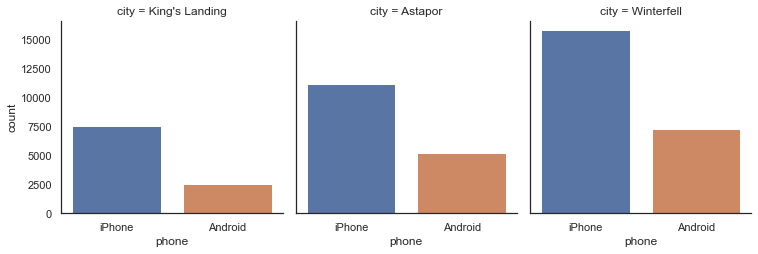

In [7]:
sns.factorplot("phone",col="city", data=driver_df, kind="count", size=3.5)

#### Overall representation of driver partner's participation in the 3 cities

Winterfell has the most driver partner participation (~1.4113x Astapor, ~2.30365x King's Landing) 

In [8]:
driver_df['city'].value_counts()

Winterfell        23336
Astapor           16534
King's Landing    10130
Name: city, dtype: int64

#### Overall representation of users that took Ultimate Black in their first 30 days

Approximately 39% of driver partners took an Ultimate Black in their first 30 days. No city has more Ultimate Black drivers in their first 30 days than driver partners that did not use Ultimate Black.

In [9]:
driver_df['ultimate_black_user'].value_counts()

False    31146
True     18854
Name: ultimate_black_user, dtype: int64

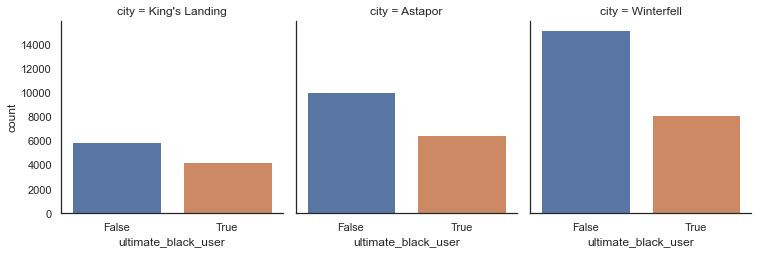

In [10]:
sns.factorplot("ultimate_black_user",col="city", data=driver_df, kind="count", size=3.5)

#### Which city has the highest percentage of trips completed in the first 30 days?

First, we augment a boolean feature column 'completed_first_trip_30' to the dataframe, 1 if the user has completed a trip within the first 30 days, 0 otherwise.

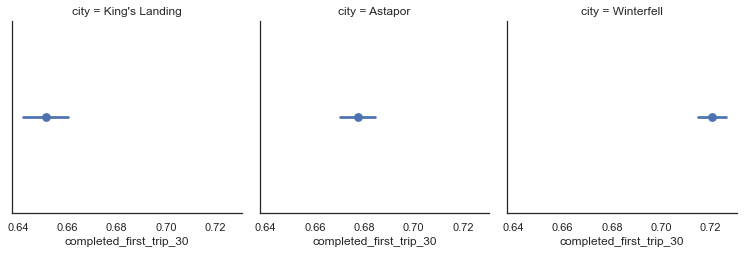

In [11]:
driver_df['completed_first_trip_30'] = \
    driver_df['trips_in_first_30_days'].map(lambda x: 1 if x is not 0 else int(x))
sns.factorplot("completed_first_trip_30",col="city", data=driver_df, kind="point", size=3.5)

Winterfell's users tend to have the highest percentage of 'trips_in_first_30_days' with approximately 72% completions, followed by Astapor with ~68% completions and lastly, King's Landing with ~65% completions.

<b><font size = "+1"> <font color="blue">What fraction of users were retained, i.e., how many of them took trips from 2014-06-01 through 2014-07-01? </font></font></b>

First we'll convert the columns 'signup_date' and 'last_trip_date' from unicode to datetime objects.

In [12]:
driver_df['signup_date'] = pd.to_datetime(driver_df['signup_date'])
driver_df['last_trip_date'] = pd.to_datetime(driver_df['last_trip_date'])

Next, identify when the last trip date was within our user dataset.

In [13]:
max(driver_df['last_trip_date'])

Timestamp('2014-07-01 00:00:00')

I am working under the assumption that a report was pulled 2014-07-01 at the end of the day; therefore, to answer the question ... I want to find those users that took a trip in the previous 30 days from 2014-07-01, since a "pull" date is not provided in the question.

In [14]:
max(driver_df['last_trip_date']) - timedelta(days = 30)

Timestamp('2014-06-01 00:00:00')

I'll create a new boolean column, 'past_30_days_trip_active', which will signal if the user's last_trip_date was after 2014-06-01 (inclusive) then calculate the fraction of observed retained users.

In [15]:
driver_df['past_30_days_trip_active']  = [1 if x >= datetime(2014,6,1) else 0 for x in driver_df['last_trip_date']]
print("{:.2f}%".format(sum(driver_df['past_30_days_trip_active'])/len(driver_df['past_30_days_trip_active']) * 100))

37.61%


<font size = "+1"> <font color = "blue">The fraction of observed retained users is answered above. </font>

### Checking for missing values

In [16]:
columns = driver_df.columns.values
all_data_accounted_for = True;
for column in columns:
    if(sum(pd.isnull(driver_df[column])) != 0):
        print('Warning: Missing \'' +  column +  '\' data.')
        all_data_accounted_for = False
        
if(all_data_accounted_for):
    print('Success: Data Set is Complete.')

#### How many missing entries are there from 'avg_rating_by_driver' and what is the relative percentage of the missing data?

In [17]:
sum(pd.isnull(driver_df['avg_rating_by_driver']) == True)

201

In [18]:
sum(pd.isnull(driver_df['avg_rating_by_driver']) == True)/driver_df.shape[0]

0.00402

#### How many missing entries are there from 'avg_rating_of_driver' and what is the relative percentage of the missing data?

In [19]:
sum(pd.isnull(driver_df['avg_rating_of_driver']) == True)

8122

In [20]:
sum(pd.isnull(driver_df['avg_rating_of_driver']) == True)/driver_df.shape[0]

0.16244

#### How many missing entries are there from 'phone'?

In [21]:
sum(pd.isnull(driver_df['phone']) == True)

396

#### What is the percentage of missing 'phone' data relative to the entire size of the data?

In [22]:
sum(pd.isnull(driver_df['phone']) == True)/driver_df.shape[0]

0.00792

#### Before we decide what to do about the missing values, lets see the distribution of the values and infer how much of the data is close to being outliers.  Let's see if there is an apparent skew in the distribution of the data using probability plots.

The feature columns 'avg_dist', 'surge_pct', 'trips_in_first_30_days', and 'avg_surge' appear to have skew bearing long tails which signals an apparent trend of larger than expected values if the data were normally distributed.  The plot for 'surge_pct' is unusually interesting but interpretable since approximately 31% of the 'surge_pct' values are 0 (reasonable since riders may not want to take Ultimate if surge pricing is in effect at larger multipliers).

#### Approximately how much of the 'surge_pct' data is 0?

In [23]:
driver_df['bool_surge_pct'] = driver_df['surge_pct'].map(lambda x: 1 if x > 0.0 else 0)
sum(driver_df['bool_surge_pct'])/len(driver_df['surge_pct'])

0.31182

In [24]:
driver_df.drop('bool_surge_pct', axis=1, inplace=True)

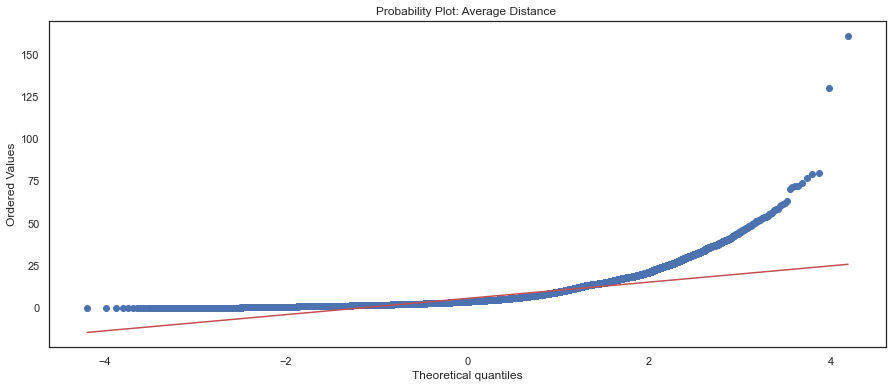

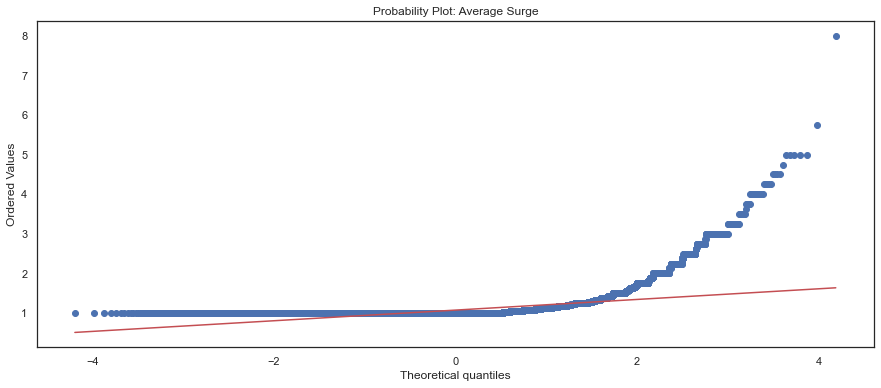

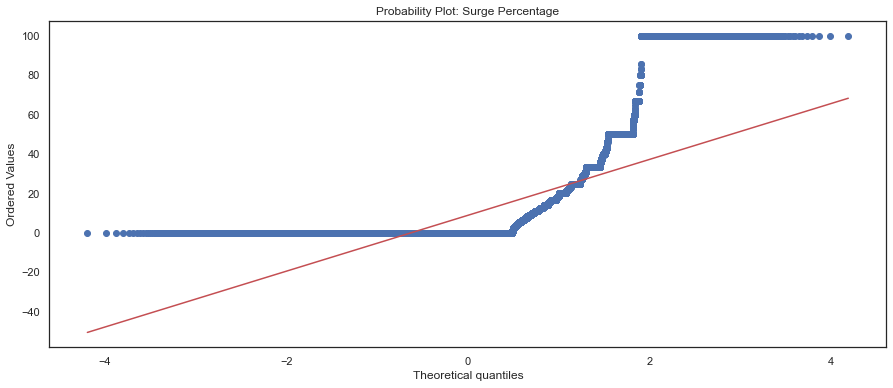

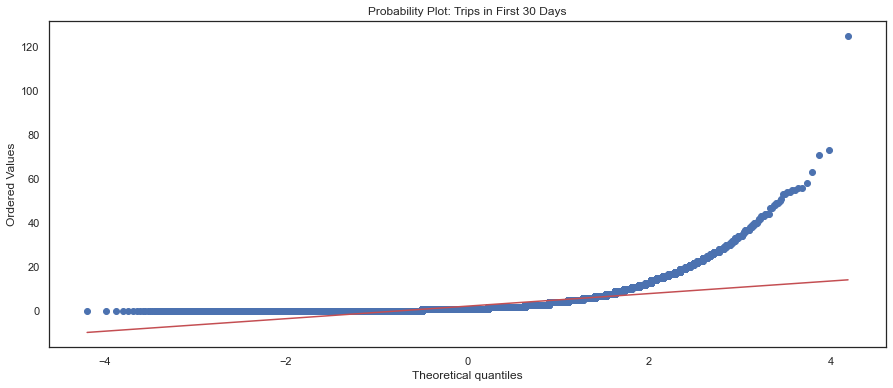

In [25]:
stats.probplot(driver_df['avg_dist'], dist="norm", plot=pylab)
pylab.title('Probability Plot: Average Distance ')
pylab.show()

stats.probplot(driver_df['avg_surge'], dist="norm", plot=pylab)
pylab.title('Probability Plot: Average Surge')
pylab.show()

stats.probplot(driver_df['surge_pct'], dist="norm", plot=pylab)
pylab.title('Probability Plot: Surge Percentage')
pylab.show()

stats.probplot(driver_df['trips_in_first_30_days'], dist="norm", plot=pylab)
pylab.title('Probability Plot: Trips in First 30 Days')
pylab.show()

Some overfitting will be expected since the model we select will learn on data which is heavily skewed in some of its features. 

###  Searching for collinearity among features

After calculating the correlation values between the features to determine the strength of the linear relationships, if they exist, there is a strong relationship between 'surge_pct' and 'avg_surge'. Better to visualize the correlation matrix over the features below to see other relationships, if they exist.

In [26]:
driver_df.corr()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,completed_first_trip_30,past_30_days_trip_active
trips_in_first_30_days,1.000000,-0.011302,-0.001841,0.005720,0.112210,0.050388,-0.136329,-0.039115,0.400560,0.210463
avg_rating_of_driver,-0.011302,1.000000,-0.026189,-0.003899,-0.002086,0.014630,0.034509,0.123175,-0.031320,-0.011653
avg_surge,-0.001841,-0.026189,1.000000,0.793582,-0.078791,-0.110071,-0.081491,0.010597,0.010328,-0.003333
surge_pct,0.005720,-0.003899,0.793582,1.000000,-0.106861,-0.144918,-0.104414,0.020103,0.011245,0.011797
ultimate_black_user,0.112210,-0.002086,-0.078791,-0.106861,1.000000,0.035998,0.032310,0.009343,0.037930,0.205002
weekday_pct,0.050388,0.014630,-0.110071,-0.144918,0.035998,1.000000,0.101652,0.020442,-0.006712,0.009693
avg_dist,-0.136329,0.034509,-0.081491,-0.104414,0.032310,0.101652,1.000000,0.080540,-0.070223,-0.092780
avg_rating_by_driver,-0.039115,0.123175,0.010597,0.020103,0.009343,0.020442,0.080540,1.000000,-0.019442,-0.026791
completed_first_trip_30,0.400560,-0.031320,0.010328,0.011245,0.037930,-0.006712,-0.070223,-0.019442,1.000000,0.018594
past_30_days_trip_active,0.210463,-0.011653,-0.003333,0.011797,0.205002,0.009693,-0.092780,-0.026791,0.018594,1.000000


<AxesSubplot:title={'center':'Feature Correlation Heatmap'}>

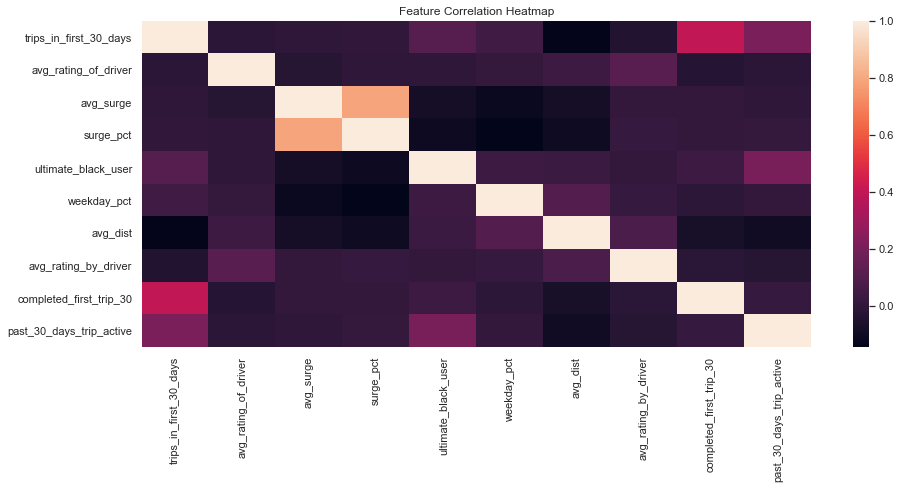

In [27]:
ax = plt.axes()
ax.set_title('Feature Correlation Heatmap')
sns.heatmap(driver_df.corr())

#### Correlation may not imply collinearity, so we we should determine if any of the features are linearly associated with another feature in our dataset outside of 'avg_surge' and 'surge_pct'.  At the very least, we can see if the relationship between the two features admit collinearity.  

If there is collinearity among the features, then the eigenvalues would be close to zero.

Text(0.5, 1.0, 'Feature Eigenvalues')

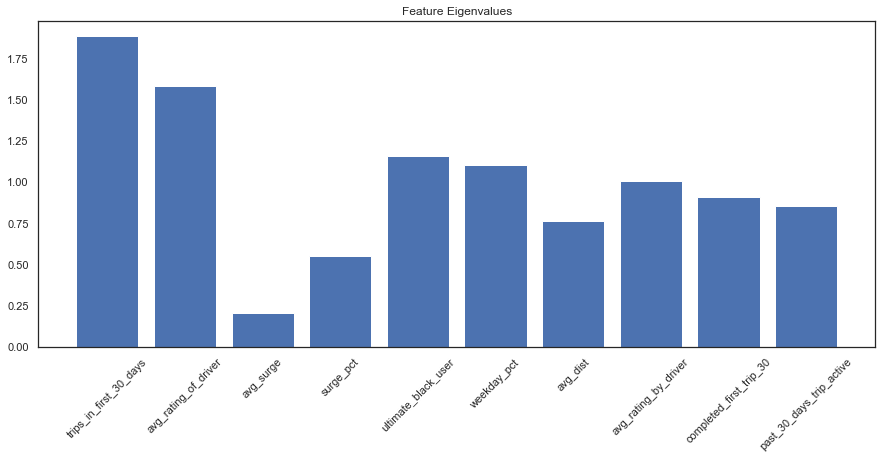

In [28]:
corr_labels = [
            'trips_in_first_30_days', 
            'avg_rating_of_driver', 
            'avg_surge', 
            'surge_pct', 
            'ultimate_black_user', 
            'weekday_pct',
            'avg_dist', 
            'avg_rating_by_driver', 
            'completed_first_trip_30', 
            'past_30_days_trip_active'
            ]

corr = driver_df.corr();
eigen_values, eigen_vector = np.linalg.eig(corr) 

plt.bar(np.arange(len(eigen_values)), eigen_values)
plt.xticks(range(len(corr_labels)), corr_labels, rotation=45)
plt.title('Feature Eigenvalues')

By in large, the eigenvalues do not signal significant collinearity.  Although, the eigenvalue corresponding to 'avg_surge' is worth investigation.  

Text(0.5, 1.0, 'avg_surge eigenvector: Detecting collinearity')

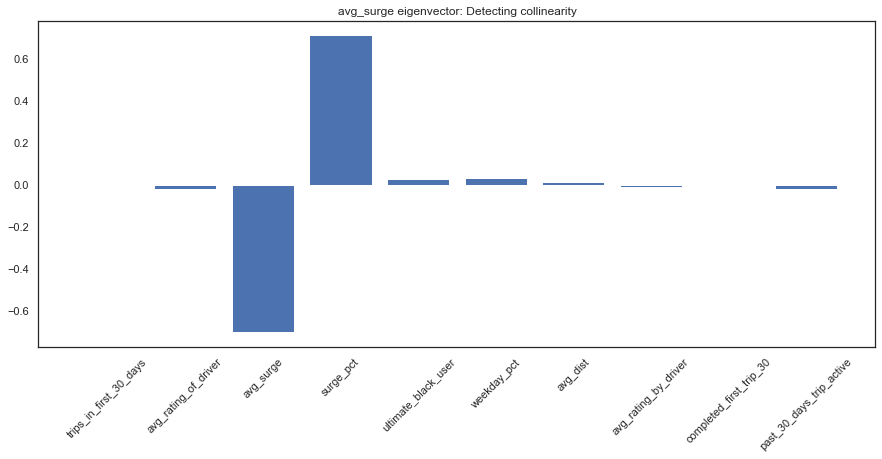

In [29]:
plt.bar(np.arange(len(eigen_vector)), eigen_vector[:,2])
plt.xticks(np.arange(len(eigen_vector)), corr_labels)
plt.xticks(rotation=45)
plt.title('avg_surge eigenvector: Detecting collinearity')

Its clear that 'avg_surge', 'surge_pct' are collinear among themselves.  We'll remove 'avg_surge'.

In [30]:
driver_df.drop('avg_surge', axis=1, inplace=True)

## Data Preparation

### dummies

There are two categorical features in the dataset, 'city' and 'phone'.  Augmenting the dataset with dummy variables signaling these feature values.

In [31]:
dummies_city = pd.get_dummies(driver_df['city'])
dummies_phone = pd.get_dummies(driver_df['phone'])

driver_df = pd.concat([driver_df,dummies_city, dummies_phone], axis=1)
driver_df.drop(['city', 'phone'], axis=1, inplace=True)

In [32]:
driver_df.head(10)

,trips_in_first_30_days,signup_date,avg_rating_of_driver,last_trip_date,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,completed_first_trip_30,past_30_days_trip_active,Astapor,King's Landing,Winterfell,Android,iPhone
0,4,2014-01-25,4.7,2014-06-17,15.4,True,46.2,3.67,5.0,1,1,0,1,0,0,1
1,0,2014-01-29,5.0,2014-05-05,0.0,False,50.0,8.26,5.0,0,0,1,0,0,1,0
2,3,2014-01-06,4.3,2014-01-07,0.0,False,100.0,0.77,5.0,1,0,1,0,0,0,1
3,9,2014-01-10,4.6,2014-06-29,20.0,True,80.0,2.36,4.9,1,1,0,1,0,0,1
4,14,2014-01-27,4.4,2014-03-15,11.8,False,82.4,3.13,4.9,1,0,0,0,1,1,0
5,2,2014-01-09,3.5,2014-06-06,0.0,True,100.0,10.56,5.0,1,1,0,0,1,0,1
6,1,2014-01-24,NaN,2014-01-25,0.0,False,100.0,3.95,4.0,1,0,1,0,0,1,0
7,2,2014-01-28,5.0,2014-01-29,0.0,False,100.0,2.04,5.0,1,0,0,0,1,0,1
8,2,2014-01-21,4.5,2014-02-01,0.0,False,100.0,4.36,5.0,1,0,0,0,1,1,0
9,1,2014-01-03,NaN,2014-01-05,0.0,False,0.0,2.37,5.0,1,0,0,0,1,1,0


### filling in NaNs

'avg_rating_of_driver' feature has NaN values present in the dataframe, will replace with zeros as long as there are not naturally reported zeros.  Will also check feature 'avg_rating_by_driver' just in case.  Lastly, 'phone' still has missing values, no data imputation should occur where data is void for this feature.

In [33]:
driver_df[driver_df['avg_rating_of_driver'] == 0.0]

,trips_in_first_30_days,signup_date,avg_rating_of_driver,last_trip_date,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,completed_first_trip_30,past_30_days_trip_active,Astapor,King's Landing,Winterfell,Android,iPhone


In [34]:
driver_df[driver_df['avg_rating_by_driver'] == 0.0]

,trips_in_first_30_days,signup_date,avg_rating_of_driver,last_trip_date,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,completed_first_trip_30,past_30_days_trip_active,Astapor,King's Landing,Winterfell,Android,iPhone


In [35]:
driver_df['avg_rating_of_driver'].fillna(0.0, inplace=True)
driver_df['avg_rating_by_driver'].fillna(0.0, inplace=True)

In [36]:
driver_df.head(10)

,trips_in_first_30_days,signup_date,avg_rating_of_driver,last_trip_date,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,completed_first_trip_30,past_30_days_trip_active,Astapor,King's Landing,Winterfell,Android,iPhone
0,4,2014-01-25,4.7,2014-06-17,15.4,True,46.2,3.67,5.0,1,1,0,1,0,0,1
1,0,2014-01-29,5.0,2014-05-05,0.0,False,50.0,8.26,5.0,0,0,1,0,0,1,0
2,3,2014-01-06,4.3,2014-01-07,0.0,False,100.0,0.77,5.0,1,0,1,0,0,0,1
3,9,2014-01-10,4.6,2014-06-29,20.0,True,80.0,2.36,4.9,1,1,0,1,0,0,1
4,14,2014-01-27,4.4,2014-03-15,11.8,False,82.4,3.13,4.9,1,0,0,0,1,1,0
5,2,2014-01-09,3.5,2014-06-06,0.0,True,100.0,10.56,5.0,1,1,0,0,1,0,1
6,1,2014-01-24,0.0,2014-01-25,0.0,False,100.0,3.95,4.0,1,0,1,0,0,1,0
7,2,2014-01-28,5.0,2014-01-29,0.0,False,100.0,2.04,5.0,1,0,0,0,1,0,1
8,2,2014-01-21,4.5,2014-02-01,0.0,False,100.0,4.36,5.0,1,0,0,0,1,1,0
9,1,2014-01-03,0.0,2014-01-05,0.0,False,0.0,2.37,5.0,1,0,0,0,1,1,0


Transform the boolean representation of 'ultimate_black_user' from explicit True, False to 1, 0 in preparation for classifier.

In [37]:
driver_df['ultimate_black_user'] = driver_df['ultimate_black_user'].map(lambda x: 1 if x is True else 0)

In [38]:
driver_df.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,last_trip_date,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,completed_first_trip_30,past_30_days_trip_active,Astapor,King's Landing,Winterfell,Android,iPhone
0,4,2014-01-25,4.7,2014-06-17,15.4,1,46.2,3.67,5.0,1,1,0,1,0,0,1
1,0,2014-01-29,5.0,2014-05-05,0.0,0,50.0,8.26,5.0,0,0,1,0,0,1,0
2,3,2014-01-06,4.3,2014-01-07,0.0,0,100.0,0.77,5.0,1,0,1,0,0,0,1
3,9,2014-01-10,4.6,2014-06-29,20.0,1,80.0,2.36,4.9,1,1,0,1,0,0,1
4,14,2014-01-27,4.4,2014-03-15,11.8,0,82.4,3.13,4.9,1,0,0,0,1,1,0


Remove the two datetime feature columns as they won't be necessary to the model as they are.

In [39]:
driver_df.drop(['signup_date', 'last_trip_date'], axis=1, inplace=True); 

### Ground Truth (target variable)

Since the goal is to build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system, we should establish 'ground-truth' and create a boolean column which identifies each user and if they were active in their 6th month.  If so, a value of 1 will be in the entry.  Otherwise, a 0 will reflect the user's inactivity in the 6th month. 

In [40]:
target = driver_df['past_30_days_trip_active']
driver_df.drop(['past_30_days_trip_active'], axis=1, inplace=True); 

## Invoking Gradient Boosting Classifier

Using train_test_split(), the function will automatically separate the entire set into training and testing sets as inputs to the gradient boosting classifier.

In [41]:
X = driver_df
y = target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=12)
gbc = GradientBoostingClassifier(learning_rate=.75)
y_pred = gbc.fit(X_train, y_train).predict(X_test)

We'll use the permutation method which randomly shuffles each feature and computes the change in the model’s performance. Since we removed the features which are highly correlated previously and our dataset is not large, we can use permutation importance to identify which features had the most performance impact.

Text(0.5, 0, 'Permutation Importance')

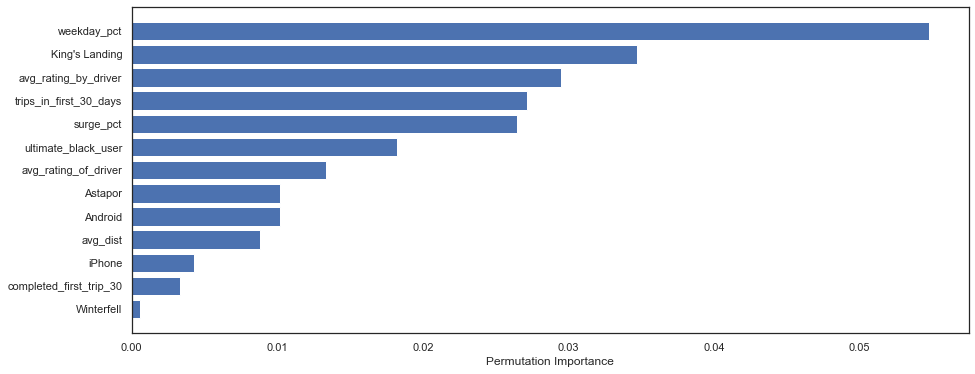

In [42]:
perm_importance = permutation_importance(gbc, X_test, y_test)
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(driver_df.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

Our engineered feature 'last_trip_strength' had the most impact in our model.

## Metrics and Validation

Accuracy:	 0.7881
Precision:	 0.7453620586475165
ROC_AUC:	 0.8528626207106683


Text(0, 0.5, 'true positive rate')

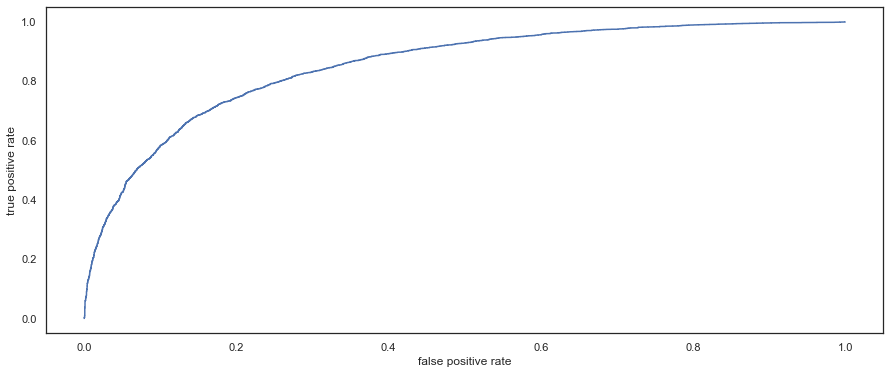

In [43]:
predictions = gbc.predict_proba(X_test)[:,1]
print("Accuracy:\t", accuracy_score(y_test, y_pred))

precisions, recalls, _ = precision_recall_curve(y_test, predictions)

print('Precision:\t',precision_score(y_test, y_pred))

fpr, tpr, _ = roc_curve(y_test, predictions)
roc_auc = roc_auc_score(y_test, predictions)

print('ROC_AUC:\t', roc_auc)

plt.plot(fpr, tpr)
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')

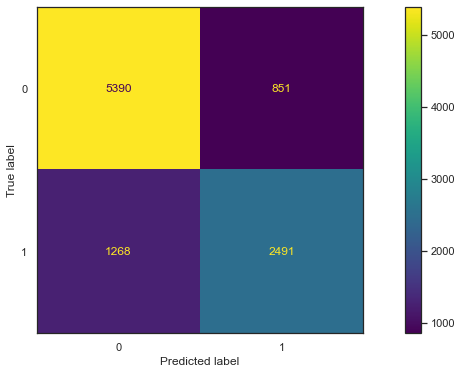

In [44]:
plot_confusion_matrix(gbc, X_test, y_test)

In [45]:
scores = cross_val_score(gbc, driver_df, target, cv=10, n_jobs=-1)
print('Cross Validation Accuracy: %.4f +/- %.4f' % (np.mean(scores), np.std(scores)))

Cross Validation Accuracy: 0.7892 +/- 0.0035


### Actionable Insights

#### weekday_pct

Users that have weekend plans to use Ultimate 40% and 75% tend to have slight peaks in ridership.  <font color="blue">Ultimate should engage users below 40% and offer rates or specials to weekend destinations to increase ridership.</font> 

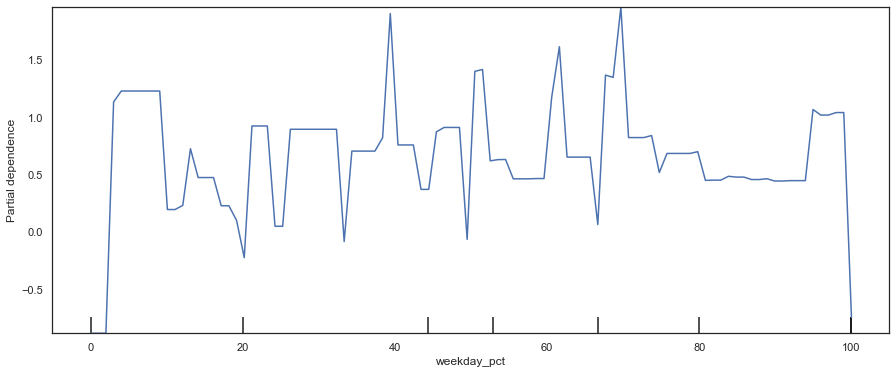

In [46]:
plot_partial_dependence(gbc, X_test, [4], feature_names=X_train.columns)

#### King's Landing

Users that signed up in King's Landing can be considered a signal to continue driver in the future over the two other cities in our dataset. <font color="blue">Uber should consider what constraints there are for drivers in other cities that are not applicable in King's Landing.</font> 

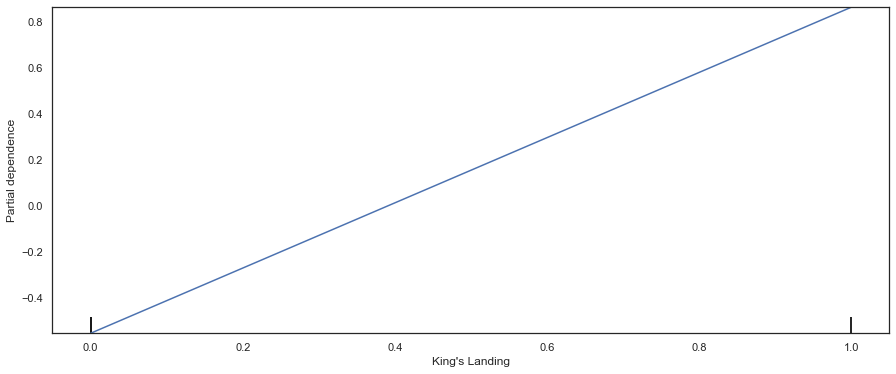

In [47]:
plot_partial_dependence(gbc, X_train, [9], feature_names=X_train.columns)

#### avg_rating_by_driver

Better passengers promote the effect of recent ridership. <font color="blue">Ultimate may want to expand the driver's ability to detail why some riders recieve lower scores in order to remediate the ridership experience.</font>

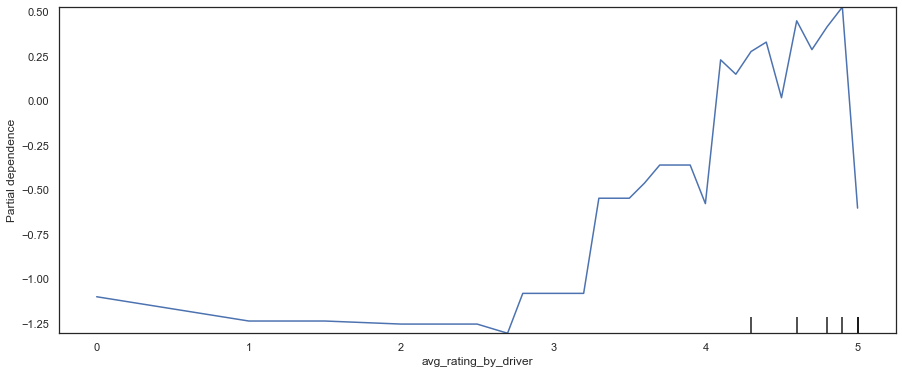

In [48]:
plot_partial_dependence(gbc, X_train, [6], feature_names=X_train.columns)